## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 1.0074916076187699
This should be close to 0: 0.0


## Choose run

In [2]:
run_name = 'RUN_NAME'

### Only if working on lx-moissard
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

from_time = 219
to_time = 220 #metadata['t_shock_exit']

date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+ '%05d' % from_time +'.nc')[0]).group(1) 

print(f'date of the simulation (DD_MM_YY): {date}')

date of the simulation (DD_MM_YY): 18_08_20


In [3]:
storing_directory_json = filepath + "../json_files/"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

name = "shock_tracking_bis_" + run_name + ".json"
path_json = Path(storing_directory_json + name)

In [4]:
with open(path_json, "r", encoding='utf-8') as shock_tracking:
            stored_data = json.load(shock_tracking)

In [5]:
stored_data.keys()

dict_keys(['00210', 'x', 'y', 'z', '00211', '00212', '00213', '00214', '00215', '00216', '00217', '00218', '00219'])

In [6]:
stored_data['00210'].keys()

dict_keys(['Vx', 'Vy', 'Vz'])

In [7]:
stored_data['00210']['Vx'].keys()

dict_keys(['(xy) plane', '(xz) plane'])

In [8]:
stored_data['00210']['Vx']['(xy) plane'].keys()

dict_keys(['y = -362.0', 'y = -361.0', 'y = -360.0', 'y = -359.0', 'y = -358.0', 'y = -357.0', 'y = -356.0', 'y = -355.0', 'y = -354.0', 'y = -353.0', 'y = -352.0', 'y = -351.0', 'y = -350.0', 'y = -349.0', 'y = -348.0', 'y = -347.0', 'y = -346.0', 'y = -345.0', 'y = -344.0', 'y = -343.0', 'y = -342.0', 'y = -341.0', 'y = -340.0', 'y = -339.0', 'y = -338.0', 'y = -337.0', 'y = -336.0', 'y = -335.0', 'y = -334.0', 'y = -333.0', 'y = -332.0', 'y = -331.0', 'y = -330.0', 'y = -329.0', 'y = -328.0', 'y = -327.0', 'y = -326.0', 'y = -325.0', 'y = -324.0', 'y = -323.0', 'y = -322.0', 'y = -321.0', 'y = -320.0', 'y = -319.0', 'y = -318.0', 'y = -317.0', 'y = -316.0', 'y = -315.0', 'y = -314.0', 'y = -313.0', 'y = -312.0', 'y = -311.0', 'y = -310.0', 'y = -309.0', 'y = -308.0', 'y = -307.0', 'y = -306.0', 'y = -305.0', 'y = -304.0', 'y = -303.0', 'y = -302.0', 'y = -301.0', 'y = -300.0', 'y = -299.0', 'y = -298.0', 'y = -297.0', 'y = -296.0', 'y = -295.0', 'y = -294.0', 'y = -293.0', 'y = -292

## Def functions

In [9]:
x = np.array(stored_data['x'])
y = np.array(stored_data['y'])
z = np.array(stored_data['z'])

In [56]:
from scipy import signal
from collections.abc import Iterable

def simplified_find_ip_shock(V, test=None, first_point=False, verbose=False):
    
    Vx, Vy, Vz = tuple(V)    

    v_slice = np.sqrt( np.array(Vx)**2
                      +np.array(Vy)**2
                      +np.array(Vz)**2 ) 
    grad_v = np.gradient(v_slice)
    
    large_grad_v = [True if grad_v[i] > 1.5 * np.nanmean(grad_v) else False for i in range(0,len(grad_v))]
    
    if not(test):
        test = large_grad_v
        
    if test:
        test = np.array(test) * np.array(large_grad_v)
                     
    ix_is = first_largest(grad_v, grad_v[test], verbose=verbose)        
    x_is = x[ix_is]    
    
    if isinstance(x_is, Iterable):
        x_is = x_is[0]

    return x_is

def simplified_check_for_absurdities(list_pos, V, first_estimation=None, verbose=False):
   
    maximum_expected_change = 10
    minimum_expected_change = 2
    
    if first_estimation:
        prev_position = first_estimation
        maximum_expected_change = 20
        minimum_expected_change = 0
    else:
        prev_position = list_pos[-2]
        
    position = list_pos[-1]
    
    absurd = False
    test = np.ones(len(V))*True
    if ( abs(prev_position - position) > maximum_expected_change or 
         abs(position - prev_position) < minimum_expected_change ):
        absurd = True
        if verbose:
            print(f'''This is absurd, the ip shock was located at {prev_position} 
                      and now it would be at {position}!''')
        test = [True if (prev_position - maximum_expected_change 
                         <  x[i]  < 
                         prev_position - minimum_expected_change) else False for i in range(0, len(V[0]))]
    else:
        if verbose:
            print("Sounds like a good position for the ip shock")

    return {'absurd': absurd, 'test': test, 'prev_position': prev_position, 'position': position}


def first_largest(list1, sub_list1, verbose=False):
    '''
    This function extracts the three largest local maxima 
    from sub_list1.
    Then, it finds the one with the smallest x
    '''
    tmp = list(sub_list1.copy())
    three_largest = []
    three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
    c1 = x[np.where(list1 == three_largest[0])][0]
    if all(np.isnan(tmp)) or not(tmp):
        candidates = [c1, 0, 0]
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
    #at this point, we have the two largest local maximas
        c2 = x[np.where(list1 == three_largest[1])][0]
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        #at this point, we have the three largest local maximas    
        c3 = x[np.where(list1 == three_largest[2])][0]
        candidates = [c1, c2, c3]
    else:
        candidates = [c1, 0, 0]

    index_first = candidates.index(min(candidates))
    index_first = MD.aplatir(np.where(x == candidates[index_first]))
    #Which of the two candidate has the smallest x
    
    if verbose:
        print(f'the chosen candidate for the position of the ip shock is {x[index_first]}')
    
    return index_first

## Trace Shock

In [57]:
verbose = False
rcParams["figure.figsize"] = [14, 10]

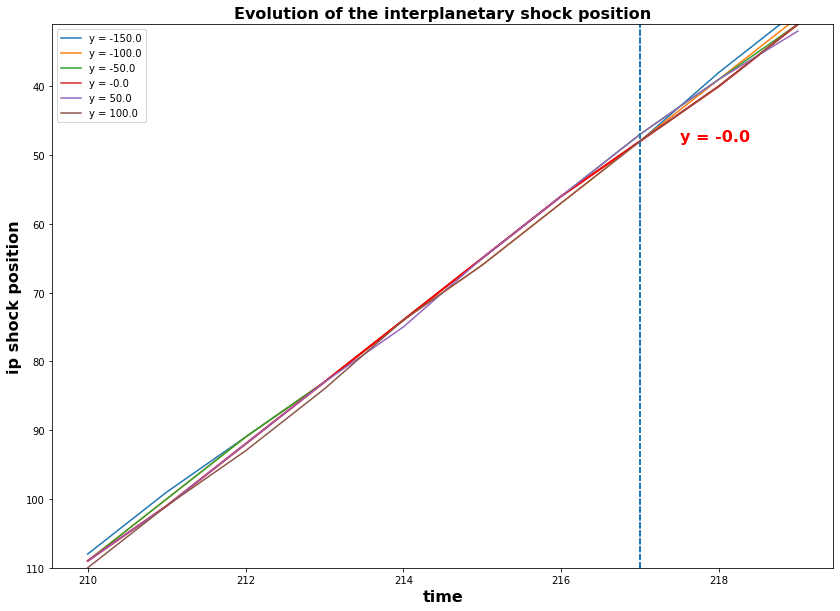

In [58]:
for y_slice in list(y[212:-212:50]):

    if verbose:
        print(y_slice)
    if y_slice == 0:
        str_y = f'y = -0.0'
    else:
        str_y = f'y = {y_slice:0.1f}'
        
    str_y_m1 = f'y = {y_slice-1:0.1f}'
    str_y_p1 = f'y = {y_slice+1:0.1f}'

    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue
            
        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None

        Vx = (1./3)*(np.array(Vx_xy[str_y_m1]) + np.array(Vx_xy[str_y]) + np.array(Vx_xy[str_y_p1]))
        Vy = (1./3)*(np.array(Vy_xy[str_y_m1]) + np.array(Vy_xy[str_y]) + np.array(Vy_xy[str_y_p1]))
        Vz = (1./3)*(np.array(Vz_xy[str_y_m1]) + np.array(Vz_xy[str_y]) + np.array(Vz_xy[str_y_p1]))
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose)
        if absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is

    plt.plot(t, pos, label=str_y)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(217, linestyle='--', )

    if y_slice == 0:
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, str_y, color='red', weight='bold', fontsize='16')
        
        
plt.legend()

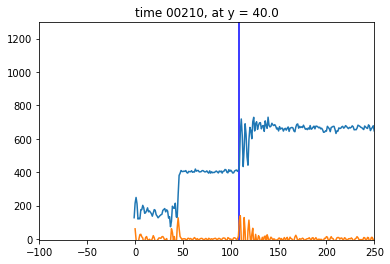

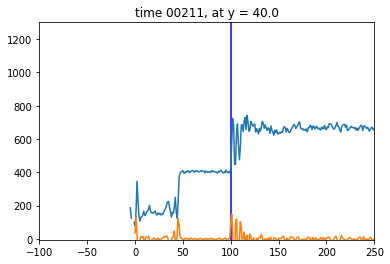

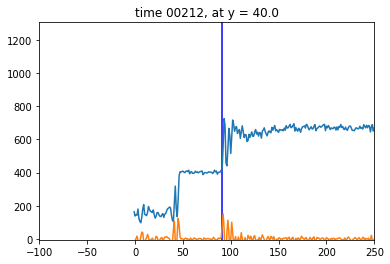

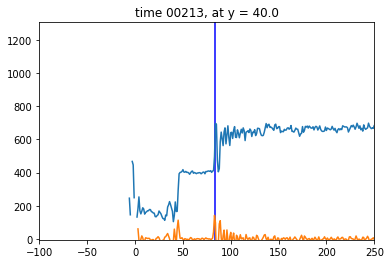

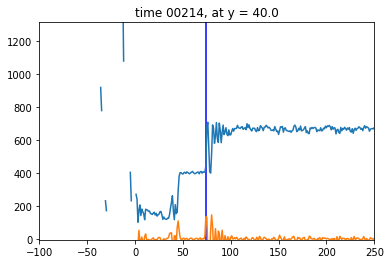

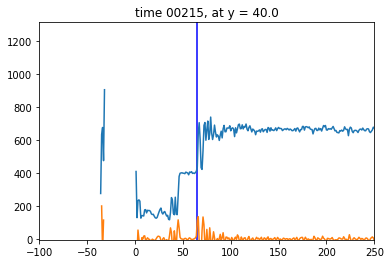

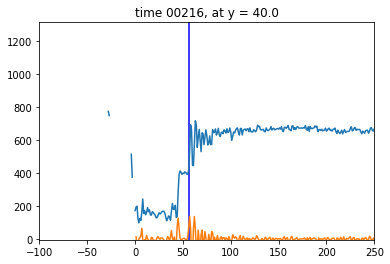

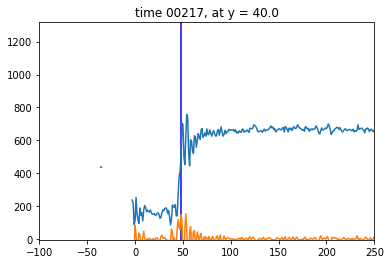

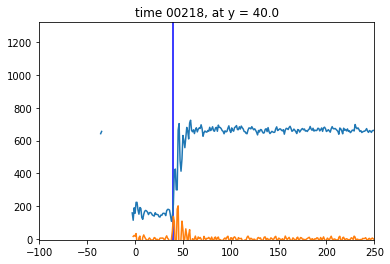

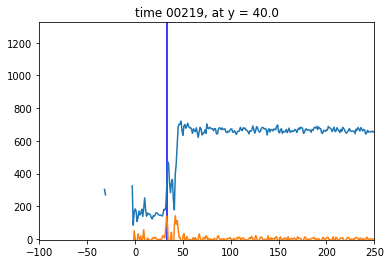

In [61]:
verbose = False

y_slice = 40
if y_slice == 0:
    str_y = f'y = -0.0'
else:
    str_y = f'y = {y_slice:0.1f}'
str_y_m1 = f'y = {y_slice-1:0.1f}'
str_y_p1 = f'y = {y_slice+1:0.1f}'

rcParams["figure.figsize"] = [6,4]
                              
for time in sorted(stored_data):
        
    if verbose:
        print(f'time = {time}')

    if not(time.isnumeric()):
        continue

    Vx_xy = stored_data[time]['Vx']['(xy) plane']
    Vy_xy = stored_data[time]['Vy']['(xy) plane']
    Vz_xy = stored_data[time]['Vz']['(xy) plane']

    if time=='00210':
        first_estimation = 115
    else:
        first_estimation = None

    Vx = (1./3)*(np.array(Vx_xy[str_y_m1]) + np.array(Vx_xy[str_y]) + np.array(Vx_xy[str_y_p1]))
    Vy = (1./3)*(np.array(Vy_xy[str_y_m1]) + np.array(Vy_xy[str_y]) + np.array(Vy_xy[str_y_p1]))
    Vz = (1./3)*(np.array(Vz_xy[str_y_m1]) + np.array(Vz_xy[str_y]) + np.array(Vz_xy[str_y_p1]))

    V = (Vx, Vy, Vz)
    
    v_slice = np.sqrt(Vx**2+Vy**2+Vz**2)

    x_is =  simplified_find_ip_shock(V, verbose=verbose)
    t.extend([int(time)])
    pos.extend([x_is])

    if verbose:
        print(f'first try x_is = {x_is}')    

    absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose)
    if absurdity['absurd']:
        test = absurdity['test']
        x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
        pos[-1] = x_is

    plt.axvline(x_is, color='blue')
    plt.plot(x, v_slice)
    plt.plot(x, np.gradient(v_slice))
    plt.xlim([-100, 250])
    plt.ylim([-5, 2*np.nanmean(v_slice)])
    plt.title(f'time {time}, at {str_y}')
    plt.show()
    
    
rcParams["figure.figsize"] = [14,10]